## Setup of system

In [1]:
import numpy as np
np.set_printoptions(precision=2) # 2 decimals when printing arrays
np.set_printoptions(suppress=True) # No scientific notation for small numbers
import matplotlib.pyplot as plt
from scipy.integrate import complex_ode, simps

from numba import njit

from quantum_systems import ODQD, GeneralOrbitalSystem # library developed by Øyvind Schøyen and others, https://github.com/Schoyen/quantum-systems

import matplotlib.animation as animation
import matplotlib.image as mpimg
from IPython.display import HTML

In [163]:
l_0 = 10                # number of basis functions
grid_length = 10        # compute from x = -10 to x = 10 in 1D
num_grid_points = 2001
omega = 0.25            # strength of harmonic oscillator potential
n = 2                   # number of particles

# this sets up the harmonic oscillator basis functions and integrals between them
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))

# this makes a spin up and spin down variant of the odho basis function and sets up the integrals between them
system = GeneralOrbitalSystem(n = n, basis_set=odho)

In [164]:
@njit
def getP(C, n):
    l = C.shape[0]
    P = np.zeros((l, l), dtype="c16")
    
    for g in range(l):
        for d in range(l):
            for i in range(n):
                P[d, g] += np.conj(C[g, i]) * C[d, i]
    return P

@njit
def getF(P, h, u):
    l = P.shape[0]
    F = np.zeros((l, l), dtype="c16")
    
    F += h
    for b in range(l):
        for a in range(l):
            for g in range(l):
                for d in range(l):
                    F[b, a] += P[d, g] * u[b, g, a, d]
    return F

def ex_x(y, system):
    expectation_pos = np.zeros(y.shape[0], dtype = complex)
    l = system.l
    pos = system.position[0]
    
    for i in range(y.shape[0]):
        Ci = y[i, :].reshape(l, l)
        P = getP(Ci, system.n)
        for b in range(l):
            for a in range(l):
                expectation_pos[i] += P[b, a] * pos[a, b]
    return expectation_pos.real

def SCF(C, system, iters = 20):
    for i in range(iters):
        P = getP(C, system.n)
        F = getF(P, system.h, system.u)
        vals, C = np.linalg.eigh(F)
    return C

In [165]:
C = np.eye(system.l, dtype="c16")

In [166]:
C = SCF(C, system, 20)

'GS 0 coefs: [-0.31  0.88 -0.    0.    0.11 -0.33  0.   -0.   -0.03  0.08 -0.    0.  0.   -0.   -0.    0.    0.   -0.   -0.    0.  ]'

'GS 1 coefs: [ 0.88  0.31 -0.   -0.   -0.33 -0.11  0.    0.    0.08  0.03 -0.   -0. -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  ]'

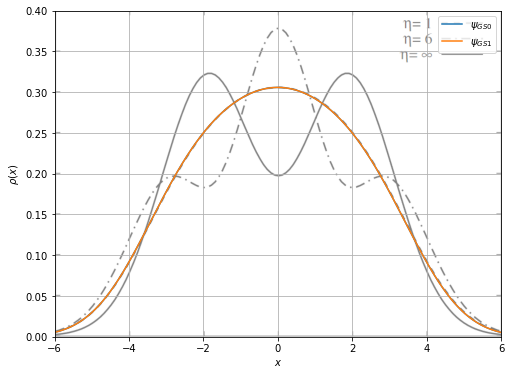

In [167]:
gs_0 = C[:, 0]
gs_1 = C[:, 1]
display(f"GS 0 coefs: {gs_0.real}".replace("\n", ""))
display(f"GS 1 coefs: {gs_1.real}".replace("\n", ""))

gs_vals_0 = np.zeros(num_grid_points, dtype = complex)
gs_vals_1 = np.zeros(num_grid_points, dtype = complex)
for i in range(system.l):
    gs_vals_0 += gs_0[i] * system.spf[i]
    gs_vals_1 += gs_1[i] * system.spf[i]



plt.figure(figsize=(8,6))
plt.plot(system.grid, np.abs(gs_vals_0)**2 / np.sum(np.abs(gs_vals_0)**2) * num_grid_points / 10, label=r"$\psi_{GS 0}$")
plt.plot(system.grid, np.abs(gs_vals_1)**2 / np.sum(np.abs(gs_vals_1)**2) * num_grid_points / 10, label=r"$\psi_{GS 1}$")

img=mpimg.imread('GS.PNG')
plt.imshow(img, extent=[-6, 6, 0, 0.4], aspect='auto', alpha = 0.5)

plt.xlim(-6, 6)
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho (x)$')
plt.grid()
plt.legend()
plt.show()

In [7]:
system.change_basis(C)
print(f"GS energy: {system.compute_reference_energy().real:.6f}")
print(f"Reference: {1.1795}")
print(f'"Exact"  : {0.8247}')
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))
system = GeneralOrbitalSystem(n = n, basis_set=odho)

GS energy: 1.179579
Reference: 1.1795
"Exact"  : 0.8247


## TDHF

In [8]:
class RHS(object):
    def __init__(self, system, eps_0, omega_e, letter = False, T = 1):
        self.l = system.l
        self.n = system.n
        self.h = system.h
        self.u = system.u
        self.pos = system.position[0]
        
        self.eps_0 = eps_0
        self.omega_e = omega_e
        if letter:
            self.laser = self.letter
            self.T = T
        else:
            self.laser = self.weak_laser
        
    def weak_laser(self, t):
        return self.eps_0 * np.sin(self.omega_e * t)
    
    def letter(self, t):
        return np.where(t < self.T, #if this
                       self.weak_laser(t) * np.sin(np.pi * t / self.T)**2, #return this
                       0) #else return this
    
    def __call__(self, t, C):
        C = C.reshape(self.l, self.l)
        P = getP(C, self.n)
        F = getF(P, self.h, self.u) - self.pos * self.laser(t)
        Cdot = -1j * F @ C

        return Cdot.reshape(-1)

In [9]:
def tdhf(C, system, f, t1, dt):
    # Setup integration parameters
    y0 = C.reshape(-1)
    t0 = 0
    N = int((t1 - t0) / dt) + 3

    t = np.zeros(N)
    t[0] = t0
    y = np.zeros((N, y0.shape[0]), dtype="c16")
    y[0] = y0
    
    # Setting up integrator and performing integration
    r = complex_ode(f).set_integrator('vode')
    r.set_initial_value(y0, t0)

    i = 1
    while r.successful() and r.t < t1:
        y[i] = r.integrate(r.t + dt)
        t[i] = r.t
        i += 1

    if (i < N): #sometimes N will be too large due to numerical inaccuracy
        t = t[:i]
        y = y[:i]
        
    return t, y

In [10]:
eps_0 = 1
omega_e = 8 * omega

t1 = 4 * 2 * np.pi / omega_e
dt = 0.001

In [11]:
f = RHS(system, eps_0, omega_e)
t, y = tdhf(C, system, f, t1, dt)

In [12]:
overlap = np.zeros(y.shape[0])
C0 = C[:,0:2]

for i in range(y.shape[0]):
    Ci = y[i, :].reshape(system.l, system.l)
    Cii = np.conj(Ci[:,0:2]).T
    overlap[i] = np.abs(np.linalg.det(Cii @ C0))**2 # overlap integral P(t,t0)

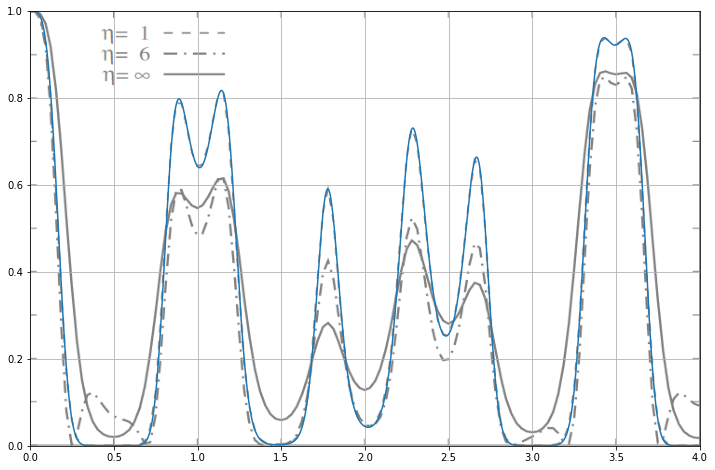

In [13]:
plt.figure(figsize=(12, 8))

unit = 2 * np.pi / omega_e
plt.plot(t / unit, overlap)

img=mpimg.imread('TD1.PNG')
plt.imshow(img, extent=[0, 4, 0, 1], aspect='auto', alpha = 0.5)

plt.grid()
plt.show()

## Experimenting with expectation values and animation

In [14]:
eps_0 = 0.1
omega_e = omega * 4

#t1 = 4 * 2 * np.pi / omega_e
t1 = 4 * 2 * np.pi / (omega * 8)
t1 *= 2
dt = 0.01

In [15]:
f = RHS(system, eps_0, omega_e)
t, y = tdhf(C, system, f, t1, dt)

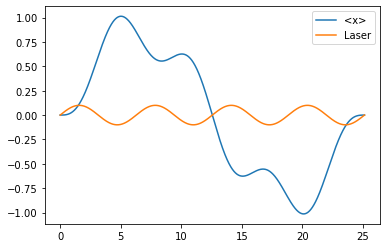

In [16]:
expectation_pos = ex_x(y, system)
plt.plot(t, expectation_pos, label = "<x>")
plt.plot(t, f.laser(t), label = "Laser")
plt.legend()
plt.show()

In [17]:
times = [i for i in range(0, len(t), len(t)//200)]
wf_amp = np.zeros((len(times), system.spf.shape[1]))
wf_amp2 = np.zeros((len(times), system.spf.shape[1]))

for i, ti in enumerate(times):
    gs = y[ti, :].reshape(system.l, system.l)[:, 0]
    swf = np.zeros(system.spf.shape[1], dtype = "c16")
    for j in range(system.l):
        swf += gs[j] * system.spf[j]
    wf_amp[i] = np.abs(swf)**2 / np.sum(np.abs(swf)**2) * num_grid_points / 10
    
    gs = y[ti, :].reshape(system.l, system.l)[:, 1]
    swf = np.zeros(system.spf.shape[1], dtype = "c16")
    for j in range(system.l):
        swf += gs[j] * system.spf[j]
    wf_amp2[i] = np.abs(swf)**2 / np.sum(np.abs(swf)**2) * num_grid_points / 10

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
plt.plot(system.grid, ODQD.HOPotential(omega)(system.grid), label = "HO")
line, = ax.plot(system.grid, wf_amp[0], label = r"$\psi_0$")
line2, = ax.plot(system.grid, wf_amp2[0], label = r"$\psi_1$")
plt.xlim(-6, 6)
plt.ylim(0, 0.4)
ax.legend()
ax.grid()

def update(i):
    line.set_ydata(wf_amp[i])
    line2.set_ydata(wf_amp2[i])

plt.close()

In [18]:
ani = animation.FuncAnimation(fig, update, frames = len(times), interval=30)
HTML(ani.to_jshtml())

## FFT

In [153]:
omega_2 = 0.25            # strength of harmonic oscillator potential

# this sets up the harmonic oscillator basis functions and integrals between them
odho_2 = ODQD(15, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega_2))

# this makes a spin up and spin down variant of the odho basis function and sets up the integrals between them
system_2 = GeneralOrbitalSystem(n = n, basis_set=odho_2)
C_2 = SCF(np.eye(system_2.l), system_2, 20)

In [178]:
eps_0 = 0.5
omega_e = omega_2 * 8

t1 = 500
dt = 0.1

In [179]:
T = 2
f = RHS(system_2, eps_0, omega_e, letter = True, T = T)
t, y = tdhf(C_2, system_2, f, t1, dt)

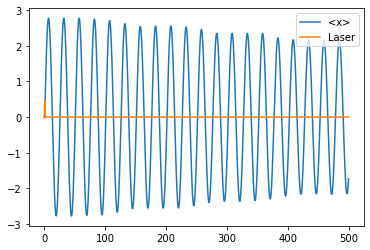

In [180]:
expectation_pos = ex_x(y, system_2)
plt.plot(t, expectation_pos, label = "<x>")
plt.plot(t, f.laser(t), label = "Laser")
plt.legend()
plt.show()

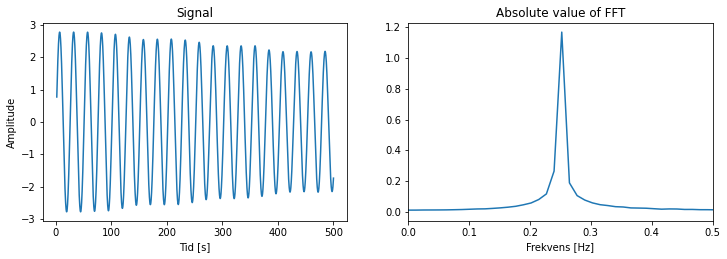

In [181]:
N0 = int(T // dt) + 1
signal = expectation_pos[N0:]
time = t[N0:]
N = len(time)

plt.figure(figsize=(12,8))
plt.subplot(221)

plt.plot(time, signal)
plt.title("Signal")
plt.xlabel("Tid [s]")
plt.ylabel("Amplitude")

plt.subplot(222)
freqs = np.fft.fftfreq(n = N, d = dt)[:N//2] * 2 * np.pi
fftGen = np.abs(np.fft.fft(signal) / N)[:N//2]

plt.plot(freqs, fftGen)
plt.title("Absolute value of FFT")
plt.xlabel("Frekvens [Hz]")
plt.xlim(0, omega_2 * 2)

plt.show()

In [182]:
idx = np.argmax(np.abs(fftGen[:N//2]))
print(f"{freqs[idx]} +- {freqs[idx] - freqs[idx-1]}")

0.252286099465151 +- 0.01261430497325755


In [146]:
print(2 * np.pi / t1)

0.06283185307179587


In [ ]:
0.5036621488721111 +- 0.006295776860901436